In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2
for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

#Wir fügen dem Datensatz ein zusätzliches Attribut hinzu, das anzeigt, ob eine gesicherte Covid-Diagnose vorlag. 
df['COV']=df['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x<4 else 2)

In [5]:
series=df[df.DIED==1].groupby(['ICU','INTUBED']).size()
series

ICU  INTUBED
1.0  1.0         5985
     2.0         1956
2.0  1.0        19898
     2.0        45471
dtype: int64

<Axes: title={'center': 'Anteil INTUBED und ICU an allen Verstorbenen'}>

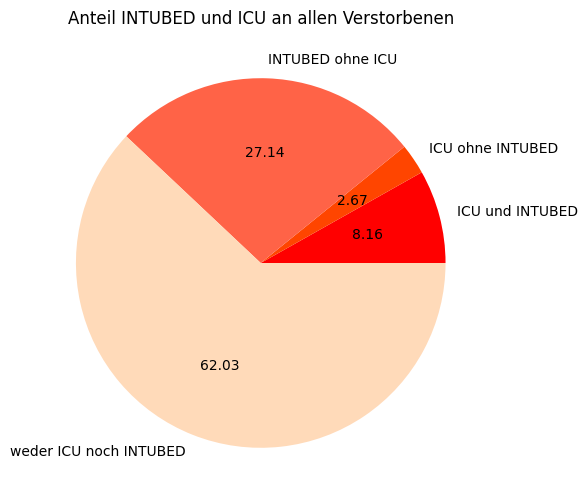

In [6]:
series.plot.pie(labels=["ICU und INTUBED", "ICU ohne INTUBED", "INTUBED ohne ICU", "weder ICU noch INTUBED"],
    colors=["r", "orangered", "tomato", "peachpuff"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil INTUBED und ICU an allen Verstorbenen")

In [7]:
series=df[df.ICU==1].groupby(['DIED','INTUBED']).size()
series

DIED  INTUBED
1     1.0        5985
      2.0        1956
2     1.0        3042
      2.0        5425
dtype: int64

<Axes: title={'center': 'Anteil DIED und INTUBED an allen Intensivpatienten'}>

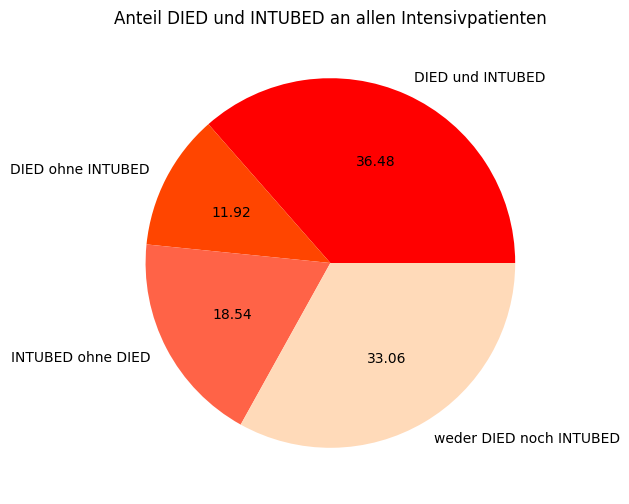

In [8]:
series.plot.pie(labels=["DIED und INTUBED", "DIED ohne INTUBED", "INTUBED ohne DIED", "weder DIED noch INTUBED"],
    colors=["r", "orangered", "tomato", "peachpuff"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil DIED und INTUBED an allen Intensivpatienten")

In [9]:
series=df[df.INTUBED==1].groupby(['DIED','ICU']).size()
series

DIED  ICU
1     1.0     5985
      2.0    19898
2     1.0     3042
      2.0     4011
dtype: int64

<Axes: title={'center': 'Anteil DIED und ICU an allen Intubierten'}>

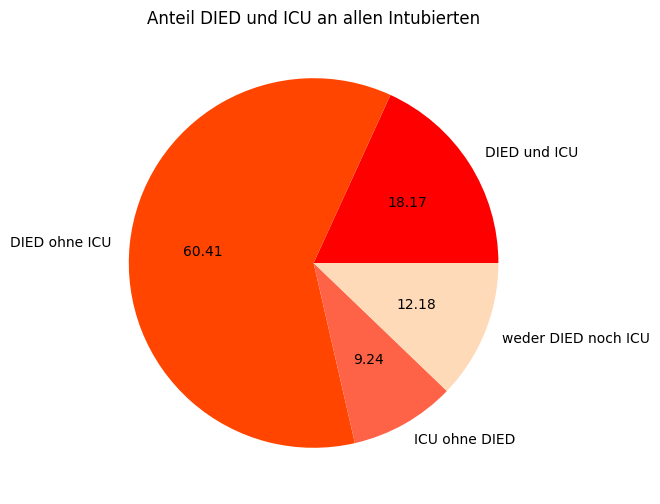

In [10]:
series.plot.pie(labels=["DIED und ICU", "DIED ohne ICU", "ICU ohne DIED", "weder DIED noch ICU"],
    colors=["r", "orangered", "tomato", "peachpuff"],autopct="%.2f",
    fontsize=10,figsize=(6, 6),title="Anteil DIED und ICU an allen Intubierten")

Text(0.5, 0.85, 'Anteil der gesichert Covid-Erkrankten an')

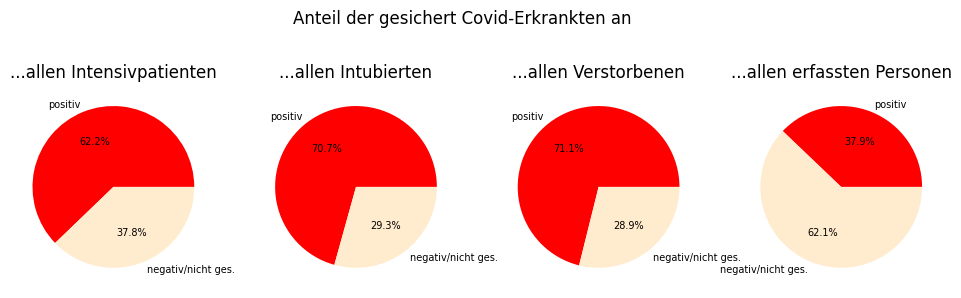

In [11]:
df1 = pd.DataFrame([df[df.ICU==1].groupby('COV').size(),df[df.INTUBED==1].groupby('COV').size(),
                    df[df.DIED==1].groupby('COV').size(),df.groupby('COV').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...allen Intensivpatienten','...allen Intubierten','...allen Verstorbenen',
                                                  '...allen erfassten Personen'],legend=False,autopct='%1.1f%%',
              labels=['positiv','negativ/nicht ges.'],ylabel='',fontsize=7,colors=['red','blanchedalmond'])
plt.suptitle('Anteil der gesichert Covid-Erkrankten an',y=0.85)


Text(0.5, 0.9, 'Von allen gesichert Covid-Erkrankten waren')

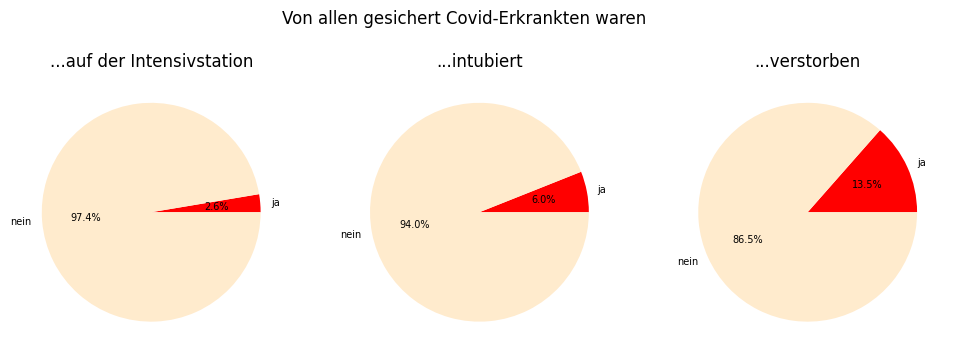

In [12]:
df1 = pd.DataFrame([df[df.COV==1].groupby('ICU').size(),df[df.COV==1].groupby('INTUBED').size(),
                    df[df.COV==1].groupby('DIED').size()])
df1.T.plot.pie(subplots=True,figsize=(12,5),title=['...auf der Intensivstation','...intubiert','...verstorben'
                                                  ],legend=False,autopct='%1.1f%%',
              labels=['ja','nein'],ylabel='',fontsize=7,colors=['red','blanchedalmond'])
plt.suptitle('Von allen gesichert Covid-Erkrankten waren',y=0.9)

In [13]:
df.DATE_DIED=df.DATE_DIED.replace('9999-99-99',np.nan)
df.DATE_DIED=pd.to_datetime(df.DATE_DIED, format='%d/%m/%Y')

Text(0.5, 1.0, 'Anzahl der Verstorbenen im Zeitverlauf')

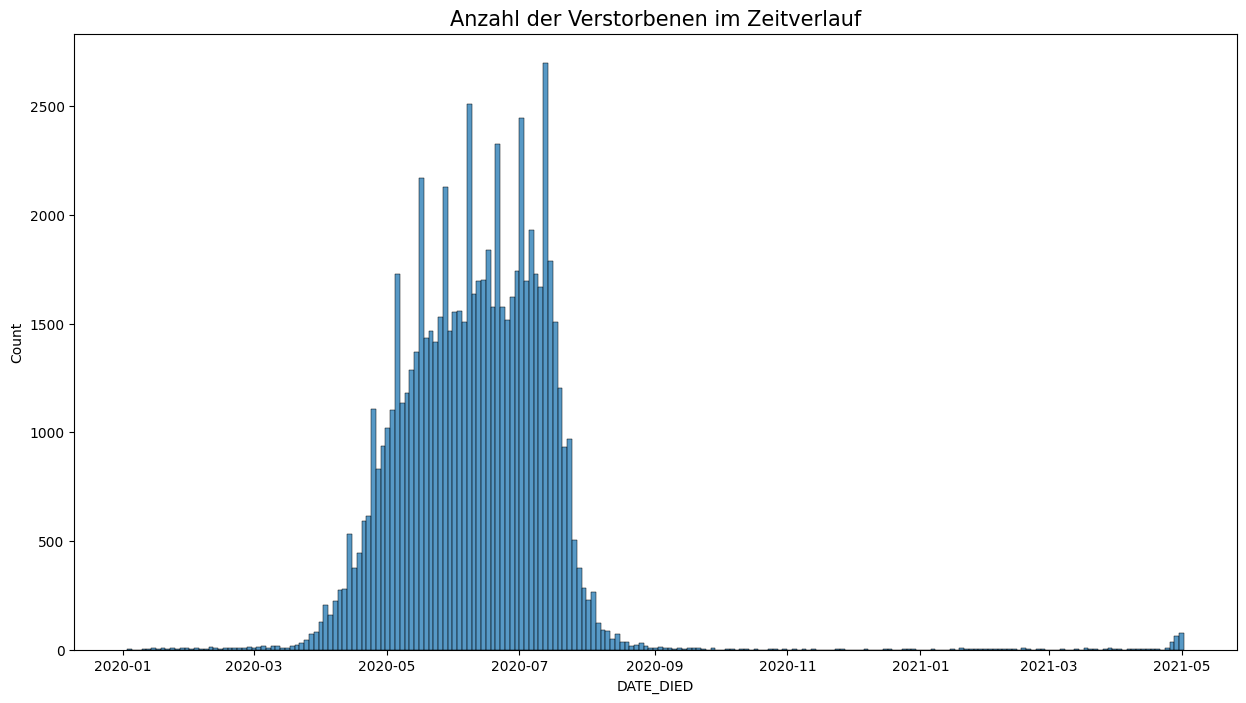

In [14]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x="DATE_DIED")
plt.title('Anzahl der Verstorbenen im Zeitverlauf', fontsize = 15)

Text(0.5, 1.0, 'Altersverteilung der Verstorbenen im Vergleich zur allgemeinen Altersverteilung')

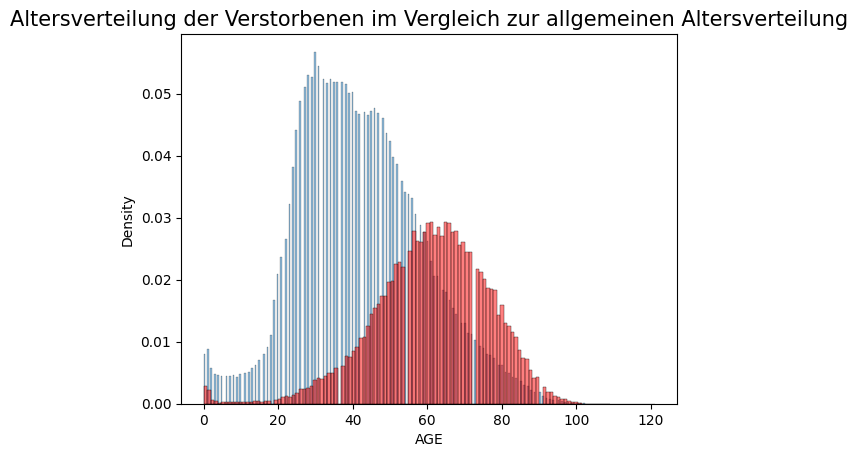

In [15]:
sns.histplot(data=df, x="AGE",stat='density',alpha=0.5)
sns.histplot(data=df[df.DIED==1], x="AGE",stat='density',color='red',alpha=0.5)
plt.title('Altersverteilung der Verstorbenen im Vergleich zur allgemeinen Altersverteilung', fontsize = 15)

In [16]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DIED',
       'COV'],
      dtype='object')

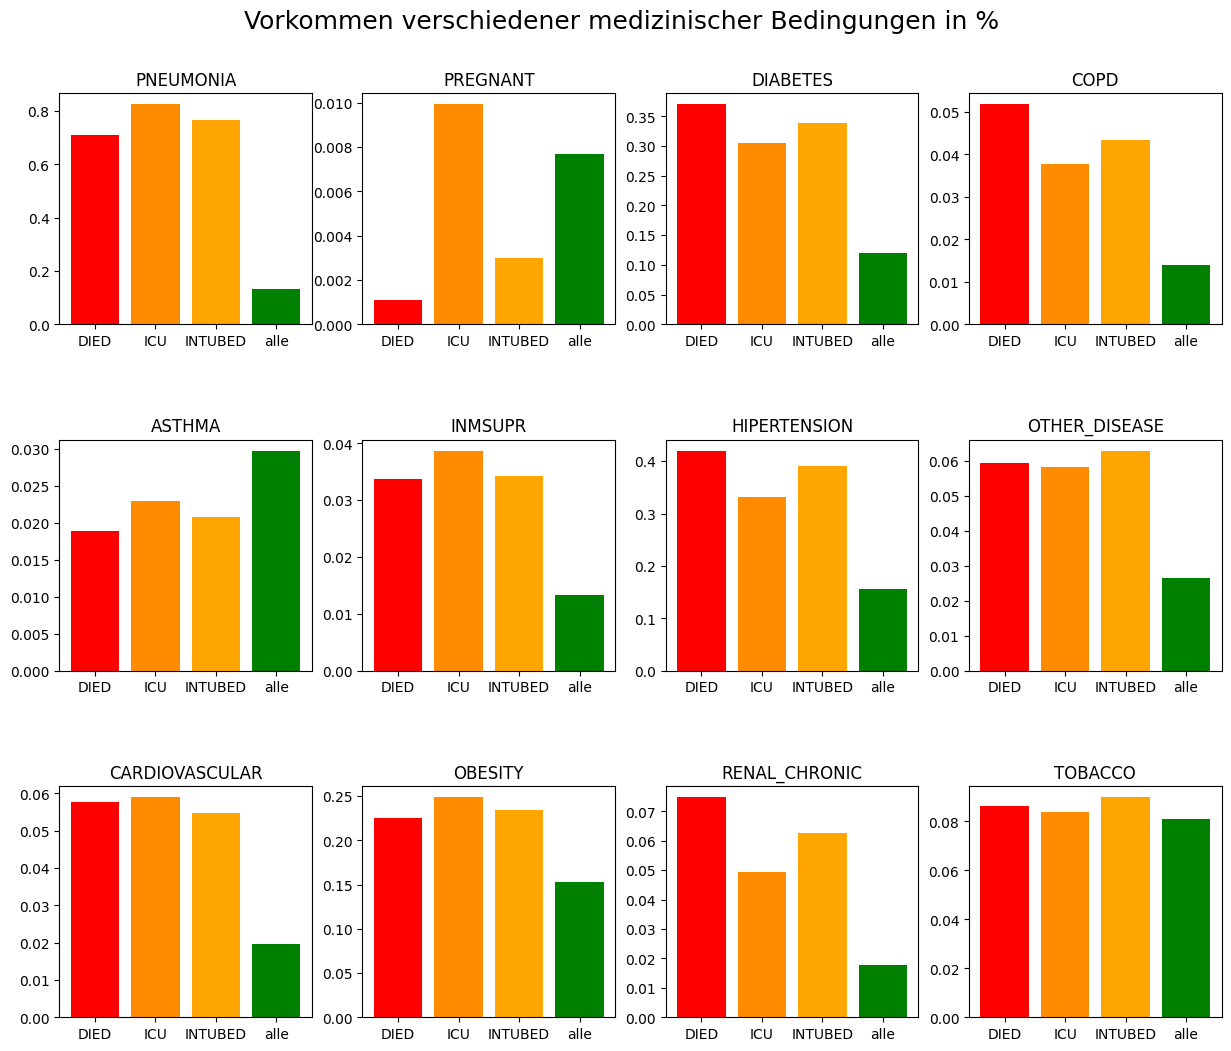

In [17]:
selected_columns=['PNEUMONIA','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
                 'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO']

def make_percentages(column):

    percentages=[len(df[(df[column]==1)&(df.DIED==1)])/len(df[df.DIED==1]),
                 len(df[(df[column]==1)&(df.ICU==1)])/len(df[df.ICU==1]),
                 len(df[(df[column]==1)&(df.INTUBED==1)])/len(df[df.INTUBED==1]),
                 len(df[df[column]==1])/len(df)]
    return percentages

x=['DIED','ICU','INTUBED','alle']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Vorkommen verschiedener medizinischer Bedingungen in %", fontsize=18, y=0.95)


for column, ax in zip(selected_columns, axs.ravel()):
    ax.bar(x,make_percentages(column),color=["red","darkorange","orange","green"])
    ax.set_title(column)

plt.show()

In [18]:
#Neue Spalte, die Anzahl medizinischer Bedingungen angibt
df['nmc']=df[selected_columns].sum(axis=1)
df['nmc']=24-df['nmc']

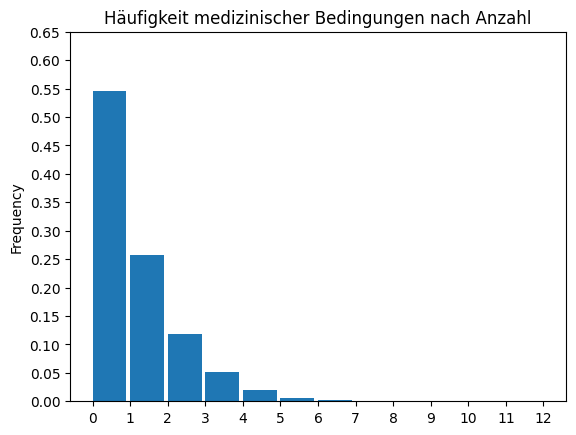

In [19]:
df.nmc.plot.hist(bins=12,density=True,width=0.9)
plt.xticks([i for i in range(0,13)])
plt.yticks([0.05*i for i in range(0,14)])
plt.title("Häufigkeit medizinischer Bedingungen nach Anzahl")
plt.show()

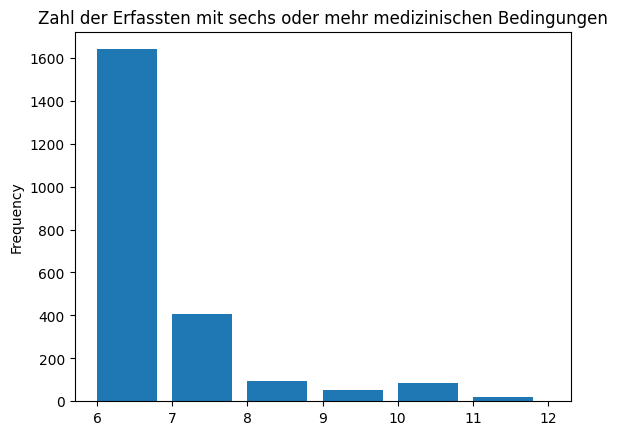

In [20]:
df.nmc[df.nmc>5].plot.hist(bins=6,width=0.8)
#plt.xticks([i for i in range(6,14)])
#plt.yticks([0.05*i for i in range(0,14)])
plt.title("Zahl der Erfassten mit sechs oder mehr medizinischen Bedingungen")
plt.show()

Text(0.5, 1.0, 'Prozentsatz der Verstorbenen, Intensivpatienten und Intubierten nach Anzahl medizinischer Bedingungen')

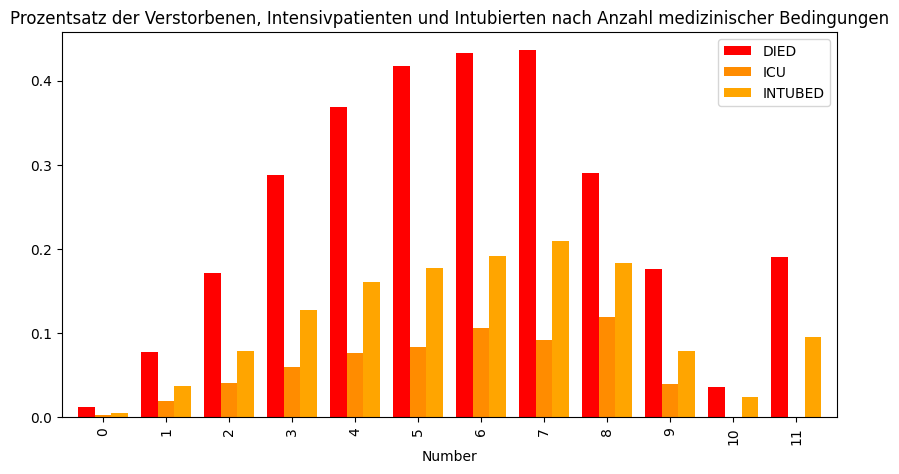

In [21]:
def make_percentages(n):

    percentages={'Number':n,'DIED':len(df[(df.nmc==n)&(df.DIED==1)])/len(df[df.nmc==n]),
                 'ICU':len(df[(df.nmc==n)&(df.ICU==1)])/len(df[df.nmc==n]),
                 'INTUBED':len(df[(df.nmc==n)&(df.INTUBED==1)])/len(df[df.nmc==n])}
    return percentages

x=['DIED','ICU','INTUBED']

df1 = pd.DataFrame(columns=['Number', 'DIED', 'ICU', 'INTUBED']) 

for i in range(0,12):
    df1.loc[len(df1)]=make_percentages(i)


df1.plot(x='Number',kind='bar',color=["red","darkorange","orange"],width=0.8,figsize=(10,5))
    #plt.set_title(number)

plt.title("Prozentsatz der Verstorbenen, Intensivpatienten und Intubierten nach Anzahl medizinischer Bedingungen")

<Axes: >

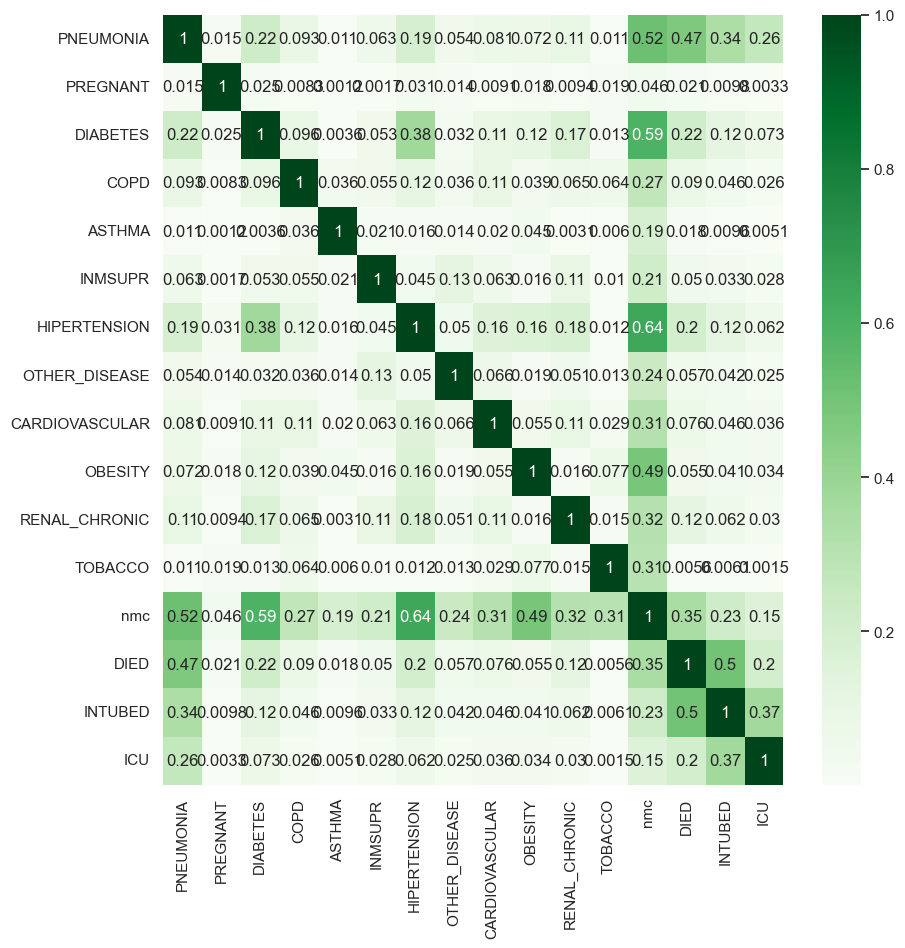

In [22]:
selected_columns.extend(['nmc','DIED','INTUBED','ICU'])
matrix = df[selected_columns].corr()
matrix=abs(matrix)
sns.set(font_scale=0.5)
sns.set(rc = {'figure.figsize':(10, 10)})
sns.heatmap(matrix, cmap="Greens", annot=True)
